In [2]:
%matplotlib inline
# Imports
import numpy as np
import pandas as pd

import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import statsmodels.api as sm
from math import floor
plt.style.use('seaborn-whitegrid')
from sklearn import linear_model
from datetime import datetime, timedelta


# Create an instance


In [5]:
start=datetime(2003,1,1); end=datetime(2009,1,1)
tickers = ["XOM","CVX"];
x = yf.download(tickers,start ,end, '1d');

[*********************100%***********************]  2 of 2 completed


In [8]:
x['Adj Close']['CVX']

Date
2003-01-02    15.939724
2003-01-03    16.061947
2003-01-06    16.428595
2003-01-07    16.087797
2003-01-08    15.993782
                ...    
2008-12-24    39.738716
2008-12-26    40.155388
2008-12-29    40.840347
2008-12-30    41.884895
2008-12-31    42.221668
Name: CVX, Length: 1511, dtype: float64

In [3]:
def cointegration(index='nasdaq', start=datetime(2003,1,1), end=datetime(2009,1,1)):
    tickers = ["XOM","CVX"];
    df = yf.download(tickers,start ,end, '1d');
    

In [ ]:
from sklearn import linear_model
import numpy as np
import pandas as pd
from scipy import stats
from math import floor
from datetime import timedelta


class PairsTradingAlgorithm(QCAlgorithm):
    
    def Initialize(self):
        
        self.SetStartDate(2009,1,1)
        self.SetEndDate(2017,1,1)
        self.SetCash(10000)
        self.numdays = 250  # set the length of training period
        tickers = ["XOM", "CVX"]
        self.symbols = []
        
        
        self.threshold = 1.
        for i in tickers:
            self.symbols.append(self.AddSecurity(SecurityType.Equity, i, Resolution.Daily).Symbol)
        for i in self.symbols:
            i.hist_window = RollingWindow[TradeBar](self.numdays) 


    def OnData(self, data):

 
        if not (data.ContainsKey("CVX") and data.ContainsKey("XOM")): return
        for symbol in self.symbols:
            symbol.hist_window.Add(data[symbol])
        
    
        price_x = pd.Series([float(i.Close) for i in self.symbols[0].hist_window], 
                             index = [i.Time for i in self.symbols[0].hist_window])
                             
        price_y = pd.Series([float(i.Close) for i in self.symbols[1].hist_window], 
                             index = [i.Time for i in self.symbols[1].hist_window])
        if len(price_x) < 250: return
        spread = self.regr(np.log(price_x), np.log(price_y))
        mean = np.mean(spread)
        std = np.std(spread)
        ratio = floor(self.Portfolio[self.symbols[1]].Price / self.Portfolio[self.symbols[0]].Price)
        # quantity = float(self.CalculateOrderQuantity(self.symbols[0],0.4)) 
        
        if spread[-1] > mean + self.threshold * std:
            if not self.Portfolio[self.symbols[0]].Quantity > 0 and not self.Portfolio[self.symbols[0]].Quantity < 0:
                self.Sell(self.symbols[1], 100) 
                self.Buy(self.symbols[0],  ratio * 100)
        
        elif spread[-1] < mean - self.threshold * std:
            if not self.Portfolio[self.symbols[0]].Quantity < 0 and not self.Portfolio[self.symbols[0]].Quantity > 0:
                self.Sell(self.symbols[0], 100)
                self.Buy(self.symbols[1], ratio * 100) 

        else:
            self.Liquidate()

    
    def regr(self,x,y):
        regr = linear_model.LinearRegression()
        x_constant = np.column_stack([np.ones(len(x)), x])
        regr.fit(x_constant, y)
        beta = regr.coef_[0]
        alpha = regr.intercept_
        spread = y - x*beta - alpha
        return spread

In [87]:
x=x.loc[:,'Adj Close']; y=y.loc[:,'Adj Close'];

<AxesSubplot:xlabel='Date'>

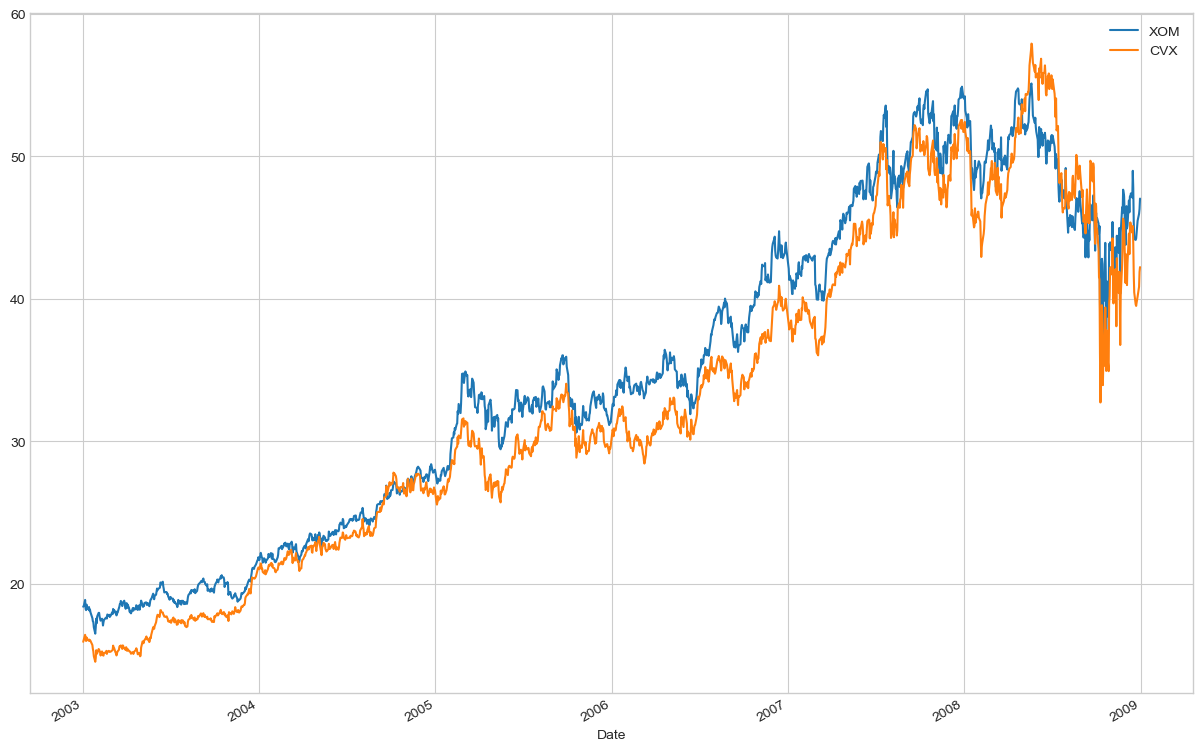

In [72]:
price = pd.concat([x, y], axis=1)
price.columns = tickers 
lp = np.log(price)
price.plot(figsize = (15,10))

In [89]:
def reg(x,y):
    regr = linear_model.LinearRegression()
    x_constant = pd.concat([x,pd.Series([1]*len(x),index = x.index)], axis=1)
    regr.fit(x_constant, y)    
    beta = regr.coef_[0]
    alpha = regr.intercept_
    spread = y - x*beta - alpha
    return spread

C:\Users\zijun\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Text(0, 0.5, 'spread')

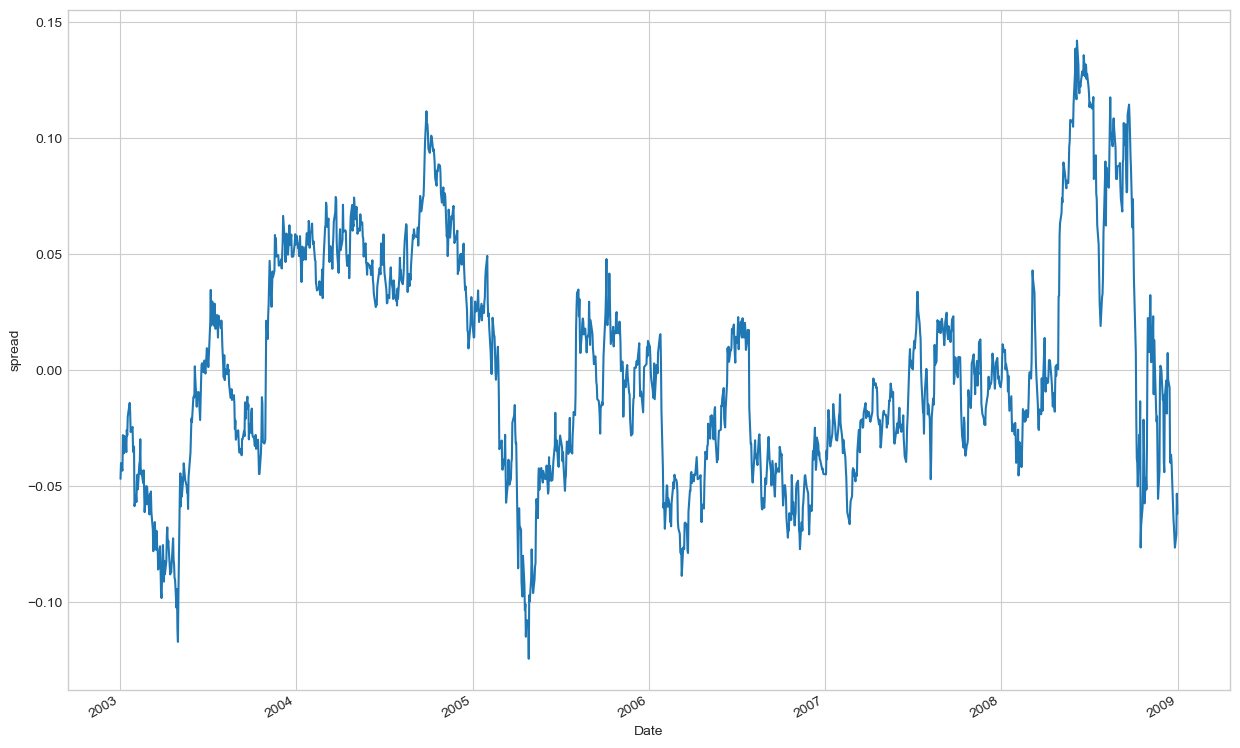

In [90]:
x = lp[tickers[0]]
y = lp[tickers[1]]
spread = reg(x,y)
# plot the spread series
spread.plot(figsize =(15,10))
plt.ylabel('spread')

In [91]:
# check if the spread is stationary 
adf = sm.tsa.stattools.adfuller(spread, maxlag=1)
print('ADF test statistic: %.02f' % adf[0])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf[1])

ADF test statistic: -3.43
	1%: -3.435
	5%: -2.863
	10%: -2.568
p-value: 0.010


In [ ]:
# A stationary time series has statistical properties or moments (e.g., mean and variance) that do not vary in time. 
# Stationarity, then, is the status of a stationary time series. 
# Conversely, nonstationarity is the status of a time series whose statistical properties are changing through time.